# Photometric Redshift Estimation

We will try to estimate the Redshift from **DES** data using the match from the VIPERS.

We use Machine Learning methods and Deep learning methods


In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Baixando Funções que serão usadas nesse notebook")
    ! shred -u astroFunctions.py
    ! wget https://raw.githubusercontent.com/rafaelmgr12/PHOTOzxcorr/main/functions/ml_functions.py -O ml_functions.py
    ! wget
    ! pip install esutil
    ! pip install healpy
    import astroFunctions as astro
    from google.colab import drive
    drive.mount('/content/drive')
else:
    import sys,os
    home = os.getenv("HOME")
    sys.path.append(home+"/Projetos/PHOTOzxcorr/functions/") # user here the path where we download the folder DESzxcoorr
    
    

## Import Libraries

In [2]:
import logging 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import os,sys
import matplotlib
from astropy.io import ascii 
from astropy.table import Table
import seaborn as sns
import time

# Regression Libraries
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras import layers
from tensorflow.keras import regularizers


# Other Libraries
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler,RobustScaler
import category_encoders as ce
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split,ShuffleSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew #for some statistics


# Neural Network Libs
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from sklearn.metrics import confusion_matrix
import keras as ks
%matplotlib inline

## Functions

Some functions that it's importants

In [3]:
def clean_tab(tab,col,val):
    tab.drop(tab[tab[col]==val].index,inplace = True)
def tts_split(X,y,size):
    rs = ShuffleSplit(n_splits=5, test_size=size, random_state=0)
    rs.get_n_splits(X)
    for train_index, test_index in rs.split(X, y): 
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test,y_train, y_test

n_folds = 5

def rmsle_cv(model,X_train,y_train):
    kf = KFold(5, shuffle=True, random_state=None).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.ravel(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def rmse_ann(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def rmse_ann2(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def rmse_ann3(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,0.75])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
    plt.ylim([0,0.75])
    plt.legend()
    plt.show()
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

## Load the Data

In [4]:
if IN_COLAB:
    path1 = "/content/drive/Shareddrives/Optical Data/DES Data/match-des-ps2"
    path2 = "/content/drive/Shareddrives/Optical Data/DES Data/results/PSPixelFit_PS1_VIPERS_VVDS"
    path3 = "/content/drive/Shareddrives/Optical Data/DES Data/64"
else:
    path1 = home+"/Projetos/PHOTOzxcorr/data/des_vipers"
    path2 = home+"/Projetos/PHOTOzxcorr/data/vipers.fits"

In [5]:
filename1 = os.listdir(path1)
#filename2 = os.listdir(path2)
#filename3 = os.listdir(path3)

In [6]:
vipers = Table.read(path2).to_pandas()

In [7]:
originalTam  = len(vipers)

In [8]:
l1 = []
for i in range(len(filename1)): # if breaks, its the RAM so read less data.
    path_dir = os.path.join(path1,filename1[i])
    df = Table.read(path_dir).to_pandas()
    l1.append(df)
des = pd.concat(l1, axis=0, ignore_index=True)
del df,l1

#l1 = []
#for i in range(len(filename2)): # if breaks, its the RAM so read less data.
#    path_dir = os.path.join(path2,filename2[i])
#    df = Table.read(path_dir).to_pandas()
#    l1.append(df)
#vvds = pd.concat(l1, axis=0, ignore_index=True)
#del df,l1

#l1= []
#for i in range(len(filename2)): # if breaks, its the RAM so read less data.
#    path_dir = os.path.join(path2,filename2[i])
#    df = Table.read(path_dir).to_pandas()
#    l1.append(df)
#ps = pd.concat(l1, axis=0, ignore_index=True)
#del df,l1

In [9]:
des.head()

COADD_OBJECT_ID         TILENAME  HPIX_32  HPIX_64  HPIX_1024  HPIX_4096  \
0         90844722  b'DES0214-0624'     4419    17677    4525480   72407680   
1         90844746  b'DES0214-0624'     4419    17677    4525474   72407593   
2         90844915  b'DES0214-0624'     4419    17677    4525474   72407593   
3         90846133  b'DES0214-0624'     4419    17677    4525474   72407592   
4         90846936  b'DES0214-0624'     4419    17677    4525474   72407584   

   HPIX_16384         RA       DEC  ALPHAWIN_J2000  ...  SPREADERR_MODEL_G  \
0  1158522880  33.836449 -6.052847       33.836449  ...           0.005871   
1  1158521488  33.871035 -6.059856       33.871035  ...           0.003286   
2  1158521488  33.871590 -6.060403       33.871590  ...           0.005051   
3  1158521481  33.856997 -6.062860       33.856997  ...           0.005198   
4  1158521353  33.880965 -6.081725       33.880965  ...           0.001357   

   SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  SPREADERR_MODEL_Y  \
0           0.004764           0.006377           0.009068           0.022757   
1           0.002815           0.002832           0.008634           0.026169   
2           0.003222           0.003506           0.008334           0.024240   
3           0.004570           0.005404           0.012816           0.033249   
4           0.000333           0.000262           0.000416           0.001871   

   WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  WAVG_SPREADERR_MODEL_I  \
0              -99.000000              -99.000000              -99.000000   
1                0.003357                0.003004                0.002559   
2                0.005884                0.003105                0.003664   
3              -99.000000                0.004608              -99.000000   
4                0.001486                0.000341                0.000254   

   WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  
0              -99.000000              -99.000000  
1              -99.000000              -99.000000  
2              -99.000000              -99.000000  
3              -99.000000              -99.000000  
4                0.000409                0.001604  

[5 rows x 213 columns]

In [10]:
des.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798485 entries, 0 to 798484
Columns: 213 entries, COADD_OBJECT_ID to WAVG_SPREADERR_MODEL_Y
dtypes: float64(181), int64(31), object(1)
memory usage: 1.3+ GB


In [11]:
des.describe()

COADD_OBJECT_ID        HPIX_32        HPIX_64     HPIX_1024  \
count     7.984850e+05  798485.000000  798485.000000  7.984850e+05   
mean      1.260091e+08    4773.278511   19094.696732  4.888369e+06   
std       7.504412e+07    1245.512028    4982.294180  1.275468e+06   
min       6.167360e+07    4419.000000   17677.000000  4.525312e+06   
25%       7.766084e+07    4421.000000   17684.000000  4.527294e+06   
50%       1.046736e+08    4423.000000   17692.000000  4.529252e+06   
75%       1.249352e+08    4425.000000   17703.000000  4.532011e+06   
max       3.129362e+08    9199.000000   36799.000000  9.420799e+06   

          HPIX_4096    HPIX_16384             RA            DEC  \
count  7.984850e+05  7.984850e+05  798485.000000  798485.000000   
mean   7.821391e+07  1.251423e+09      34.364467      -5.114362   
std    2.040749e+07  3.265198e+08       2.871225       0.716713   
min    7.240499e+07  1.158480e+09      28.827405      -6.575953   
25%    7.243671e+07  1.158987e+09      31.920415      -5.721844   
50%    7.246805e+07  1.159489e+09      34.247986      -5.134024   
75%    7.251219e+07  1.160195e+09      36.839562      -4.511865   
max    1.507328e+08  2.411725e+09      40.076229      -3.583469   

       ALPHAWIN_J2000  DELTAWIN_J2000  ...  SPREADERR_MODEL_G  \
count   798485.000000   798485.000000  ...       7.984850e+05   
mean        34.364467       -5.114362  ...       3.492581e+01   
std          2.871225        0.716713  ...       9.531751e+03   
min         28.827405       -6.575953  ...       0.000000e+00   
25%         31.920415       -5.721844  ...       2.547285e-03   
50%         34.247986       -5.134024  ...       4.599462e-03   
75%         36.839562       -4.511865  ...       7.319062e-03   
max         40.076229       -3.583469  ...       5.300929e+06   

       SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  \
count      798485.000000      798485.000000      798485.000000   
mean            1.517826           0.003468           1.350570   
std           743.628314           0.002482         679.953556   
min             0.000000           0.000011           0.000000   
25%             0.001445           0.001460           0.002072   
50%             0.002944           0.002968           0.004224   
75%             0.004861           0.005032           0.007111   
max        480721.343750           0.039847      594851.375000   

       SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  \
count       7.984850e+05           798485.000000           798485.000000   
mean        1.321988e+03              -52.288596              -28.598305   
std         5.278878e+05               49.422795               45.163794   
min         0.000000e+00              -99.000000              -99.000000   
25%         6.391507e-03              -99.000000              -99.000000   
50%         1.198860e-02              -99.000000                0.001321   
75%         1.863970e-02                0.002363                0.002842   
max         4.055787e+08                1.093628             4411.679688   

       WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  
count           798485.000000           798485.000000           798485.000000  
mean               -27.915442              -44.795427              -80.400782  
std                 44.548196               49.277485               38.671127  
min                -99.000000              -99.000000              -99.000000  
25%                -99.000000              -99.000000              -99.000000  
50%                  0.001357                0.000579              -99.000000  
75%                  0.002862                0.002546              -99.000000  
max                  0.845378                0.356951                1.529472  

[8 rows x 212 columns]

In [12]:
vipers.head()

ID       RA_1     DEC_1       z  z_Err     flag  \
0  b'VIPERS 110183204'  30.938091 -4.777137  0.8625 -9.999  b' 2.2'   
1  b'VIPERS 107103627'  36.644029 -5.977520  0.8799 -9.999  b' 2.5'   
2  b'VIPERS 107103628'  36.672479 -5.977282  0.5614 -9.999  b' 4.4'   
3  b'VIPERS 107103698'  36.678549 -5.976197  0.8175 -9.999  b' 2.5'   
4  b'VIPERS 107103810'  36.810072 -5.976481  0.9880 -9.999  b' 3.5'   

      source comments  totobs  totexp  ...  SPREADERR_MODEL_R  \
0  b'VIPERS'     b'-'      -9      -9  ...           0.005274   
1  b'VIPERS'     b'-'      -9      -9  ...           0.002011   
2  b'VIPERS'     b'-'      -9      -9  ...           0.000984   
3  b'VIPERS'     b'-'      -9      -9  ...           0.002790   
4  b'VIPERS'     b'-'      -9      -9  ...           0.004319   

  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  SPREADERR_MODEL_Y  \
0          0.003328           0.004998           0.017579   
1          0.001790           0.002247           0.011369   
2          0.000720           0.000835           0.003422   
3          0.001830           0.002291           0.009595   
4          0.002232           0.001744           0.008616   

   WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  WAVG_SPREADERR_MODEL_I  \
0              -99.000000              -99.000000                0.003946   
1                0.003144                0.003403                0.002033   
2                0.002639                0.001304                0.000754   
3                0.003182                0.004029                0.002431   
4              -99.000000                0.006201                0.002499   

   WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y    random  
0              -99.000000              -99.000000  0.846429  
1                0.002936              -99.000000  0.080008  
2                0.000884                0.003498  0.522909  
3                0.002787              -99.000000  0.891630  
4                0.002281              -99.000000  0.693547  

[5 rows x 224 columns]

In [13]:
vipers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47658 entries, 0 to 47657
Columns: 224 entries, ID to random
dtypes: float32(2), float64(184), int32(2), int64(31), object(5)
memory usage: 80.7+ MB


In [14]:
vipers.describe()

RA_1         DEC_1             z      z_Err   totobs   totexp  \
count  47658.000000  47658.000000  47658.000000  47658.000  47658.0  47658.0   
mean      34.366382     -5.114805      0.712314     -9.999     -9.0     -9.0   
std        2.436109      0.508098      0.193470      0.000      0.0      0.0   
min       30.189261     -5.980062      0.000000     -9.999     -9.0     -9.0   
25%       32.229905     -5.568142      0.582200     -9.999     -9.0     -9.0   
50%       34.301013     -5.115527      0.694700     -9.999     -9.0     -9.0   
75%       36.436138     -4.706329      0.833300     -9.999     -9.0     -9.0   
max       38.802245     -4.171540      3.388400     -9.999     -9.0     -9.0   

       COADD_OBJECT_ID       HPIX_32       HPIX_64     HPIX_1024  ...  \
count     4.765800e+04  47658.000000  47658.000000  4.765800e+04  ...   
mean      1.134666e+08   4488.047841  17953.698267  4.596273e+06  ...   
std       5.711826e+07    555.697804   2222.853004  5.690584e+05  ...   
min       6.350901e+07   4419.000000  17677.000000  4.525397e+06  ...   
25%       8.012918e+07   4421.000000  17684.000000  4.527211e+06  ...   
50%       1.018255e+08   4422.000000  17689.000000  4.528621e+06  ...   
75%       1.188991e+08   4425.000000  17700.000000  4.531396e+06  ...   
max       3.107449e+08   9199.000000  36799.000000  9.420718e+06  ...   

       SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  \
count       47658.000000       47658.000000       47658.000000   
mean            0.002280           0.001967           0.002879   
std             0.006614           0.001106           0.006690   
min             0.000000           0.000027           0.000024   
25%             0.001312           0.001138           0.001526   
50%             0.002033           0.001798           0.002515   
75%             0.002901           0.002575           0.003784   
max             1.000000           0.012570           1.000000   

       SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  \
count       4.765800e+04            47658.000000            47658.000000   
mean        5.737221e+01              -36.718419               -4.409988   
std         6.381133e+03               47.823946               20.429569   
min         0.000000e+00              -99.000000              -99.000000   
25%         4.762461e-03              -99.000000                0.001244   
50%         7.841216e-03                0.001891                0.001992   
75%         1.175007e-02                0.003256                0.002830   
max         1.134550e+06                0.904770                0.275968   

       WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  \
count            47658.000000            47658.000000            47658.000000   
mean                -1.657755              -12.293176              -71.626298   
std                 12.711090               32.652090               44.281237   
min                -99.000000              -99.000000              -99.000000   
25%                  0.001153                0.001120              -99.000000   
50%                  0.001831                0.002086              -99.000000   
75%                  0.002595                0.003269                0.001698   
max                  0.134029                0.111382                0.101630   

             random  
count  47658.000000  
mean       0.499443  
std        0.288370  
min        0.000007  
25%        0.250870  
50%        0.500371  
75%        0.748744  
max        0.999957  

[8 rows x 219 columns]

**Counting the Galaxies of our Catalog**

In [15]:
pix = des['HPIX_1024'].unique()
pix_match = vipers["HPIX_1024"].unique()

In [16]:
num_des = []
avg_des = []
num_vipers = []
avg_vipers = []
for i in range(len(pix)):
    avg_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].mean())
    num_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].count())
for i in range(len(pix_match)):  
    avg_vipers.append(vipers[vipers['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].mean())
    num_vipers.append(vipers[vipers['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].count())

In [17]:
avg_des = np.asarray(avg_des)
num_des = np.asarray(num_des)

avg_vipers = np.asarray(avg_vipers)
num_vipers = np.asarray(num_vipers)

In [18]:
galaxies_des = pd.DataFrame(pix,columns=['HPIX_1024'])
galaxies_vipers = pd.DataFrame(pix_match,columns=['HPIX_1024'])
galaxies_des['AVG_des'] = avg_des
galaxies_des['COUNT_des'] = num_des
galaxies_vipers['AVG_vipers'] = avg_vipers
galaxies_vipers['COUNT_vipers'] = num_vipers

In [19]:
galaxies_vipers.head()

HPIX_1024  AVG_vipers  COUNT_vipers
0    4533248   22.036404            16
1    4526506   21.741598             3
2    4526505   20.686842             5
3    4526502   21.758568             6
4    4526501   22.131912             5

In [20]:
galaxies_des.head()

HPIX_1024    AVG_des  COUNT_des
0    4525480  22.349606        139
1    4525474  22.359484        157
2    4525472  22.441808        153
3    4525374  22.552263         93
4    4525367  22.219650        117

In [21]:
print("Galaxies in VIPERSxDES match: ",galaxies_vipers['COUNT_vipers'].sum(),"\n Galaxies in Des",galaxies_des['COUNT_des'].sum())

Galaxies in VIPERSxDES match:  47658 
 Galaxies in Des 798485


In [22]:
pix_des = galaxies_des.HPIX_1024.values
pix_vipers = galaxies_vipers.HPIX_1024.values

In [23]:
diff = np.setdiff1d(pix_des,pix_vipers)
diff

array([4525312, 4525313, 4525314, ..., 9420797, 9420798, 9420799])

In [24]:
num_des = []
avg_des = []
for i in range(len(pix_vipers)):
    avg_des.append(des[des['HPIX_1024']==pix_vipers[i]]['MAG_AUTO_I'].mean())
    num_des.append(des[des['HPIX_1024']==pix_vipers[i]]['MAG_AUTO_I'].count())

In [25]:
avg_des = np.asarray(avg_des)
num_des = np.asarray(num_des)


In [26]:
galaxies_desd = pd.DataFrame(pix_vipers,columns=['HPIX_1024'])
galaxies_desd['AVG_des'] = avg_des
galaxies_desd['COUNT_des'] = num_des

In [27]:
print("Galaxies contained in the DES catalogue",galaxies_desd['COUNT_des'].sum())

Galaxies contained in the DES catalogue 507187


In [28]:
print("Galaxies that are not contained in the match",galaxies_desd['COUNT_des'].sum()-galaxies_vipers["COUNT_vipers"].sum())

Galaxies that are not contained in the match 459529


**Before the cleaning**

In [29]:
count1, n1 = np.histogram(des['MAG_AUTO_R'],bins = np.linspace(0,30,100))
count2, n2 = np.histogram(vipers['MAG_AUTO_R'],bins = np.linspace(0,30,100))

<ipython-input-30-9100a005af15>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(n2[:-1],(count2/count1))


Text(0.5, 0, 'Object in  MAG_AUTO_R')

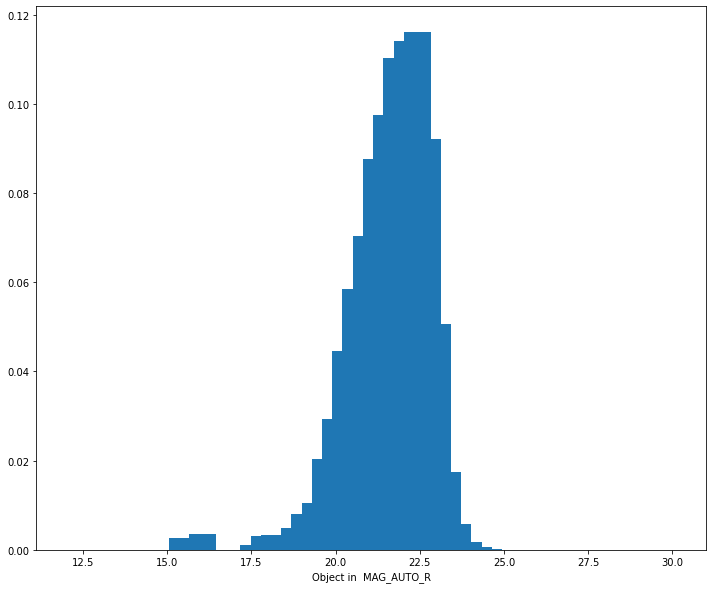

In [30]:
plt.figure(figsize=(12,10))
plt.bar(n2[:-1],(count2/count1))
plt.xlabel("Object in  MAG_AUTO_R")
#plt.ylim(0.8)

## Processing the data

We have some parts of our data that are **null**(not measured) values,

In [31]:
feat = ['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
            "WAVG_SPREAD_MODEL_G","WAVG_SPREAD_MODEL_R","WAVG_SPREAD_MODEL_I","WAVG_SPREAD_MODEL_Z","WAVG_SPREAD_MODEL_Y",
            "WAVG_FLUX_PSF_G","WAVG_FLUX_PSF_R","WAVG_FLUX_PSF_I","WAVG_FLUX_PSF_Z","WAVG_FLUX_PSF_Y",
            "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"]


In [32]:
vipers[(vipers[feat[0]]==99) | (vipers[feat[0]]==-99)][feat[0]]

203      99.0
255      99.0
462      99.0
1287     99.0
1308     99.0
         ... 
47089    99.0
47110    99.0
47387    99.0
47398    99.0
47439    99.0
Name: MAG_AUTO_G, Length: 209, dtype: float64

In [33]:
for j in feat:
    print(j,":",len(vipers[(vipers[j]==99) | (vipers[j]==-99)][j]),"\n")

MAG_AUTO_G : 209 

MAG_AUTO_R : 8 

MAG_AUTO_I : 0 

MAG_AUTO_Z : 13 

MAG_AUTO_Y : 702 

WAVG_SPREAD_MODEL_G : 17677 

WAVG_SPREAD_MODEL_R : 2124 

WAVG_SPREAD_MODEL_I : 799 

WAVG_SPREAD_MODEL_Z : 5919 

WAVG_SPREAD_MODEL_Y : 34481 

WAVG_FLUX_PSF_G : 17677 

WAVG_FLUX_PSF_R : 2124 

WAVG_FLUX_PSF_I : 799 

WAVG_FLUX_PSF_Z : 5919 

WAVG_FLUX_PSF_Y : 34481 

WAVG_MAG_PSF_G : 17677 

WAVG_MAG_PSF_R : 2124 

WAVG_MAG_PSF_I : 799 

WAVG_MAG_PSF_Z : 5919 

WAVG_MAG_PSF_Y : 34481 



We have seen the null values of a data.

It is necessary to treat the data, to do so , first we want to maintain $95\%-97\%$ of our original data



In [34]:
for i in feat:
    print(i," is ",100*len(vipers[(vipers[i]==99) | (vipers[i]==-99)][j])/len(vipers),"%")

MAG_AUTO_G  is  0.4385412732384909 %
MAG_AUTO_R  is  0.016786268832095348 %
MAG_AUTO_I  is  0.0 %
MAG_AUTO_Z  is  0.027277686852154936 %
MAG_AUTO_Y  is  1.4729950900163666 %
WAVG_SPREAD_MODEL_G  is  37.09135926811868 %
WAVG_SPREAD_MODEL_R  is  4.4567543749213145 %
WAVG_SPREAD_MODEL_I  is  1.6765285996055226 %
WAVG_SPREAD_MODEL_Z  is  12.419740652146544 %
WAVG_SPREAD_MODEL_Y  is  72.35091694993496 %
WAVG_FLUX_PSF_G  is  37.09135926811868 %
WAVG_FLUX_PSF_R  is  4.4567543749213145 %
WAVG_FLUX_PSF_I  is  1.6765285996055226 %
WAVG_FLUX_PSF_Z  is  12.419740652146544 %
WAVG_FLUX_PSF_Y  is  72.35091694993496 %
WAVG_MAG_PSF_G  is  37.09135926811868 %
WAVG_MAG_PSF_R  is  4.4567543749213145 %
WAVG_MAG_PSF_I  is  1.6765285996055226 %
WAVG_MAG_PSF_Z  is  12.419740652146544 %
WAVG_MAG_PSF_Y  is  72.35091694993496 %


Therefore, we have the percentage of null values in our dataset.

Here I make a choice for a our data, but first we make a further analysis.


In [35]:
vipers[vipers["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].mean()

20.70985353786413

In [36]:
vipers[vipers["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].median()

20.75017547607422

In [37]:
vipers[vipers["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].std()

0.512853228902346

In [38]:
vipers[vipers["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].min()

15.231805801391602

In [39]:
vipers[vipers["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].max()

22.031143188476562

Here we make one choice, change the values of $99$ for the median values of the WAVG_MAG_PSF_Y

In [40]:
vipers.loc[vipers[feat[15]]==99,feat[15]] = vipers[vipers[feat[15]]!=99][feat[15]].max()
vipers.loc[vipers[feat[16]]==99,feat[16]] = vipers[vipers[feat[16]]!=99][feat[16]].max()
vipers.loc[vipers[feat[17]]==99,feat[17]] = vipers[vipers[feat[17]]!=99][feat[17]].max()
vipers.loc[vipers[feat[18]]==99,feat[18]] = vipers[vipers[feat[18]]!=99][feat[18]].max()
vipers.loc[vipers[feat[19]]==99,feat[19]] = vipers[vipers[feat[19]]!=99][feat[19]].max()

In [41]:
for i in feat:
    print(i," is ",100*len(vipers[(vipers[i]==99) | (vipers[i]==-99)][j])/len(vipers),"%")

MAG_AUTO_G  is  0.4385412732384909 %
MAG_AUTO_R  is  0.016786268832095348 %
MAG_AUTO_I  is  0.0 %
MAG_AUTO_Z  is  0.027277686852154936 %
MAG_AUTO_Y  is  1.4729950900163666 %
WAVG_SPREAD_MODEL_G  is  37.09135926811868 %
WAVG_SPREAD_MODEL_R  is  4.4567543749213145 %
WAVG_SPREAD_MODEL_I  is  1.6765285996055226 %
WAVG_SPREAD_MODEL_Z  is  12.419740652146544 %
WAVG_SPREAD_MODEL_Y  is  72.35091694993496 %
WAVG_FLUX_PSF_G  is  37.09135926811868 %
WAVG_FLUX_PSF_R  is  4.4567543749213145 %
WAVG_FLUX_PSF_I  is  1.6765285996055226 %
WAVG_FLUX_PSF_Z  is  12.419740652146544 %
WAVG_FLUX_PSF_Y  is  72.35091694993496 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


In [42]:
vipers.loc[vipers[feat[4]]==99,feat[4]] = vipers[vipers[feat[4]]!=99][feat[4]].median()
vipers.loc[vipers[feat[0]]==99,feat[0]] = vipers[vipers[feat[0]]!=99][feat[0]].median()
vipers.loc[vipers[feat[3]]==99,feat[3]] = vipers[vipers[feat[3]]!=99][feat[3]].max()


In [43]:
for i in feat:
    print(i," is ",100*len(vipers[(vipers[i]==99) | (vipers[i]==-99)][j])/len(vipers),"%")

MAG_AUTO_G  is  0.0 %
MAG_AUTO_R  is  0.016786268832095348 %
MAG_AUTO_I  is  0.0 %
MAG_AUTO_Z  is  0.0 %
MAG_AUTO_Y  is  0.0 %
WAVG_SPREAD_MODEL_G  is  37.09135926811868 %
WAVG_SPREAD_MODEL_R  is  4.4567543749213145 %
WAVG_SPREAD_MODEL_I  is  1.6765285996055226 %
WAVG_SPREAD_MODEL_Z  is  12.419740652146544 %
WAVG_SPREAD_MODEL_Y  is  72.35091694993496 %
WAVG_FLUX_PSF_G  is  37.09135926811868 %
WAVG_FLUX_PSF_R  is  4.4567543749213145 %
WAVG_FLUX_PSF_I  is  1.6765285996055226 %
WAVG_FLUX_PSF_Z  is  12.419740652146544 %
WAVG_FLUX_PSF_Y  is  72.35091694993496 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


In [44]:
for j in feat[1:4]:
    clean_tab(vipers,j,99)

In [45]:
print("With this choice we maintain",100*(len(vipers)/originalTam))

With this choice we maintain 99.98321373116791


In [46]:
for i in feat:
    print(i," is ",100*len(vipers[(vipers[i]==99) | (vipers[i]==-99)][j])/len(vipers),"%")

MAG_AUTO_G  is  0.0 %
MAG_AUTO_R  is  0.0 %
MAG_AUTO_I  is  0.0 %
MAG_AUTO_Z  is  0.0 %
MAG_AUTO_Y  is  0.0 %
WAVG_SPREAD_MODEL_G  is  37.084994753410285 %
WAVG_SPREAD_MODEL_R  is  4.442812172088143 %
WAVG_SPREAD_MODEL_I  is  1.6726128016789088 %
WAVG_SPREAD_MODEL_Z  is  12.417628541448058 %
WAVG_SPREAD_MODEL_Y  is  72.34837355718783 %
WAVG_FLUX_PSF_G  is  37.084994753410285 %
WAVG_FLUX_PSF_R  is  4.442812172088143 %
WAVG_FLUX_PSF_I  is  1.6726128016789088 %
WAVG_FLUX_PSF_Z  is  12.417628541448058 %
WAVG_FLUX_PSF_Y  is  72.34837355718783 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


## Plots

Some plot to understand, the best features to use

The features choose for our analysis is


* **WAVG_FLUX_PSF_G,R,I,Z,Y Weighted average flux measurement of PSF fit single epoch detections [ADU]**
* **MAG_AUTO_G,R,I,Z,Y Magnitude estimation, for an elliptical model based on the Kron radius [mag]**
* **WAVG_SPREAD_MODEL_G,R,I,Z,Y SPREAD MODEL using the weighted averaged values from single epoch detections**
* **WAVG_MAG_PSF_G,R,I,Z,Y Weighted average magnitude, of PSF fit single epoch detections [mag]**

**Plots for the completeza**

In [47]:
count1, n1 = np.histogram(des['MAG_AUTO_R'],bins = np.linspace(0,30,100))
count2, n2 = np.histogram(vipers['MAG_AUTO_R'],bins = np.linspace(0,30,100))

<ipython-input-48-9100a005af15>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(n2[:-1],(count2/count1))


Text(0.5, 0, 'Object in  MAG_AUTO_R')

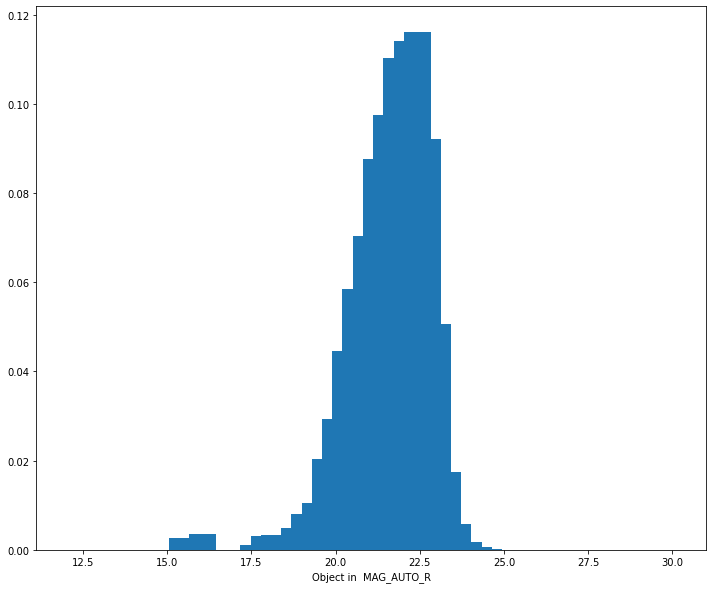

In [48]:
plt.figure(figsize=(12,10))
plt.bar(n2[:-1],(count2/count1))
plt.xlabel("Object in  MAG_AUTO_R")
#plt.ylim(0.8)

In [49]:
feat.append("z")

<Figure size 2880x2304 with 0 Axes>

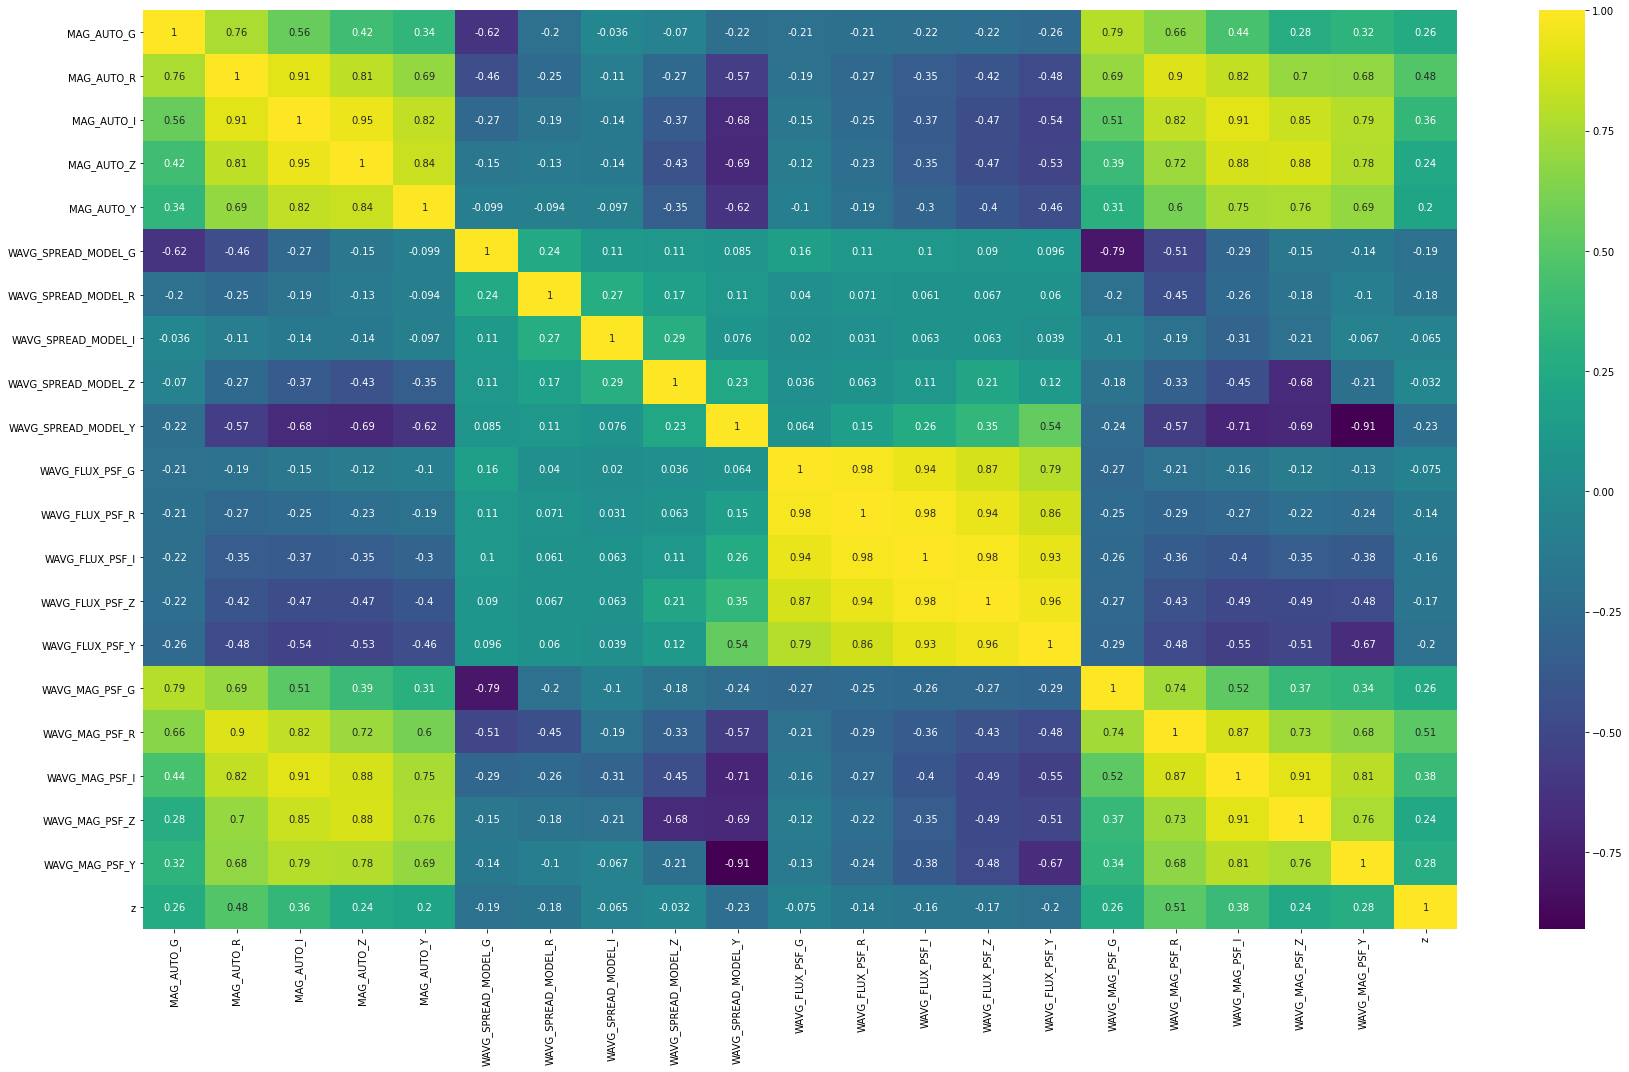

In [50]:
plt.figure(figsize=(40,32))
corrmat = vipers[feat].corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat,annot=True,cmap="viridis")
plt.tight_layout()

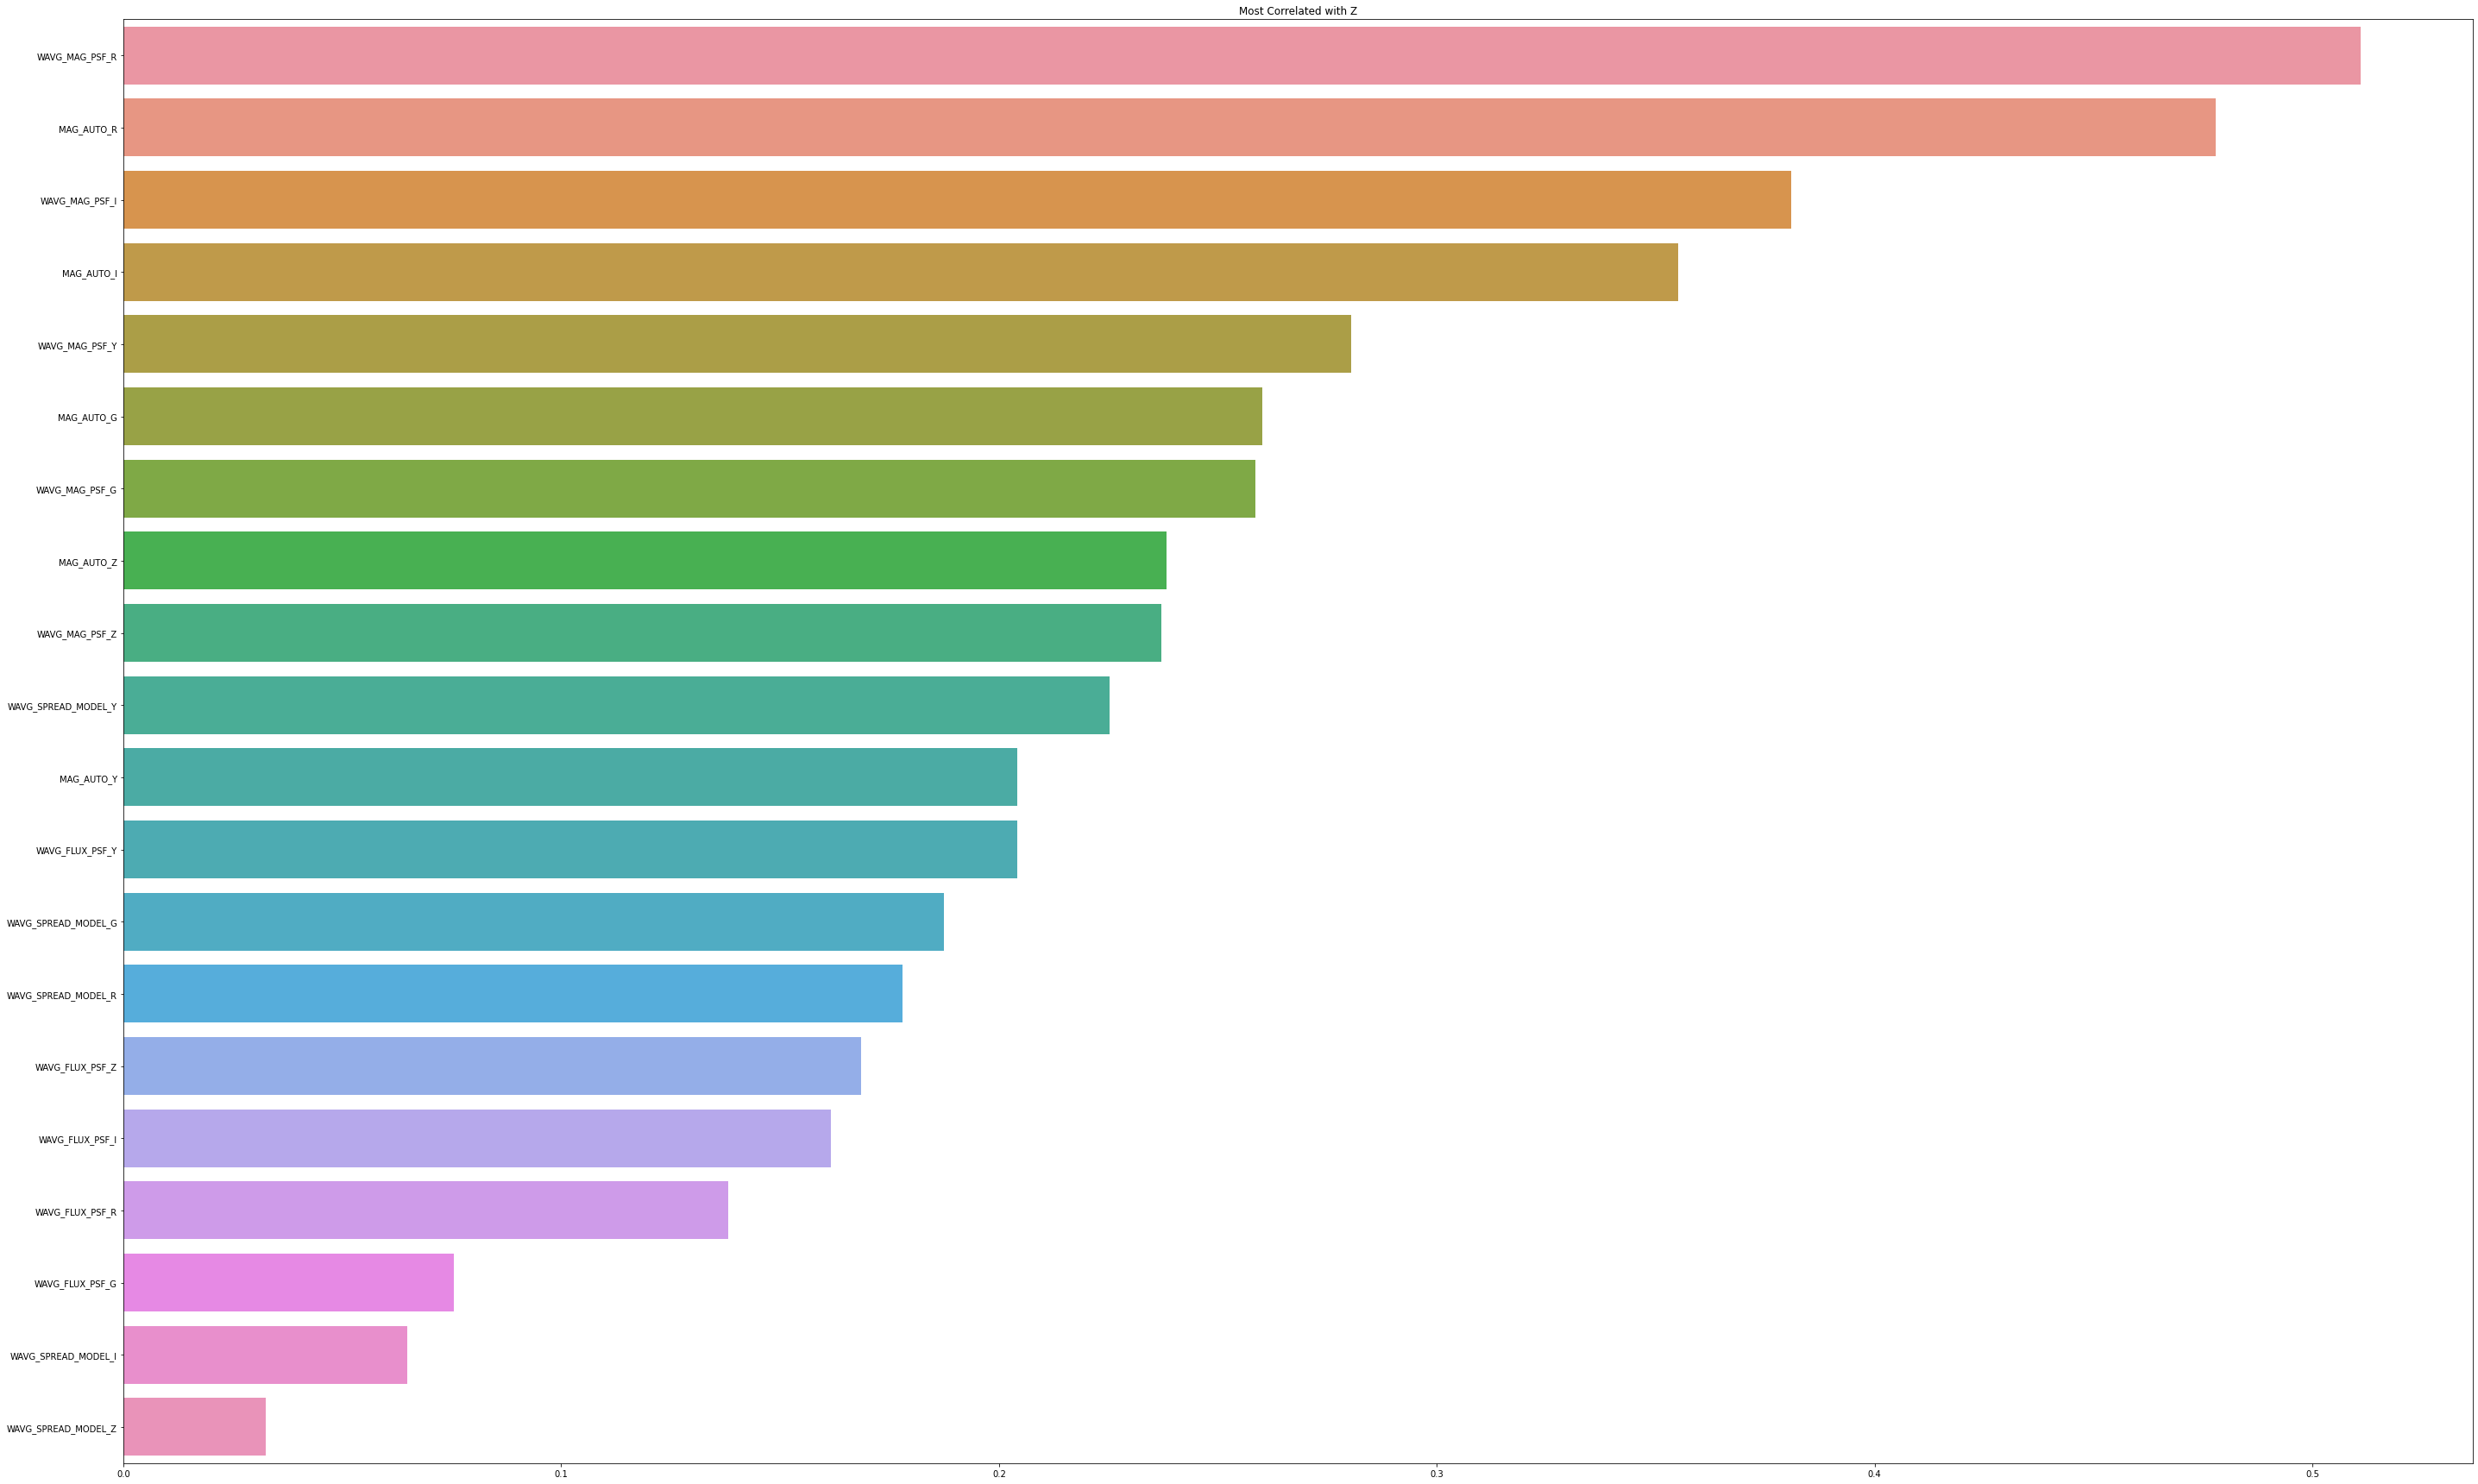

In [51]:
plt.figure(figsize=(40,24))
correlations =corrmat.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()
plt.savefig("correlations.png",dpi = 500,bbox_inches = "tight" )

<Figure size 1152x576 with 0 Axes>

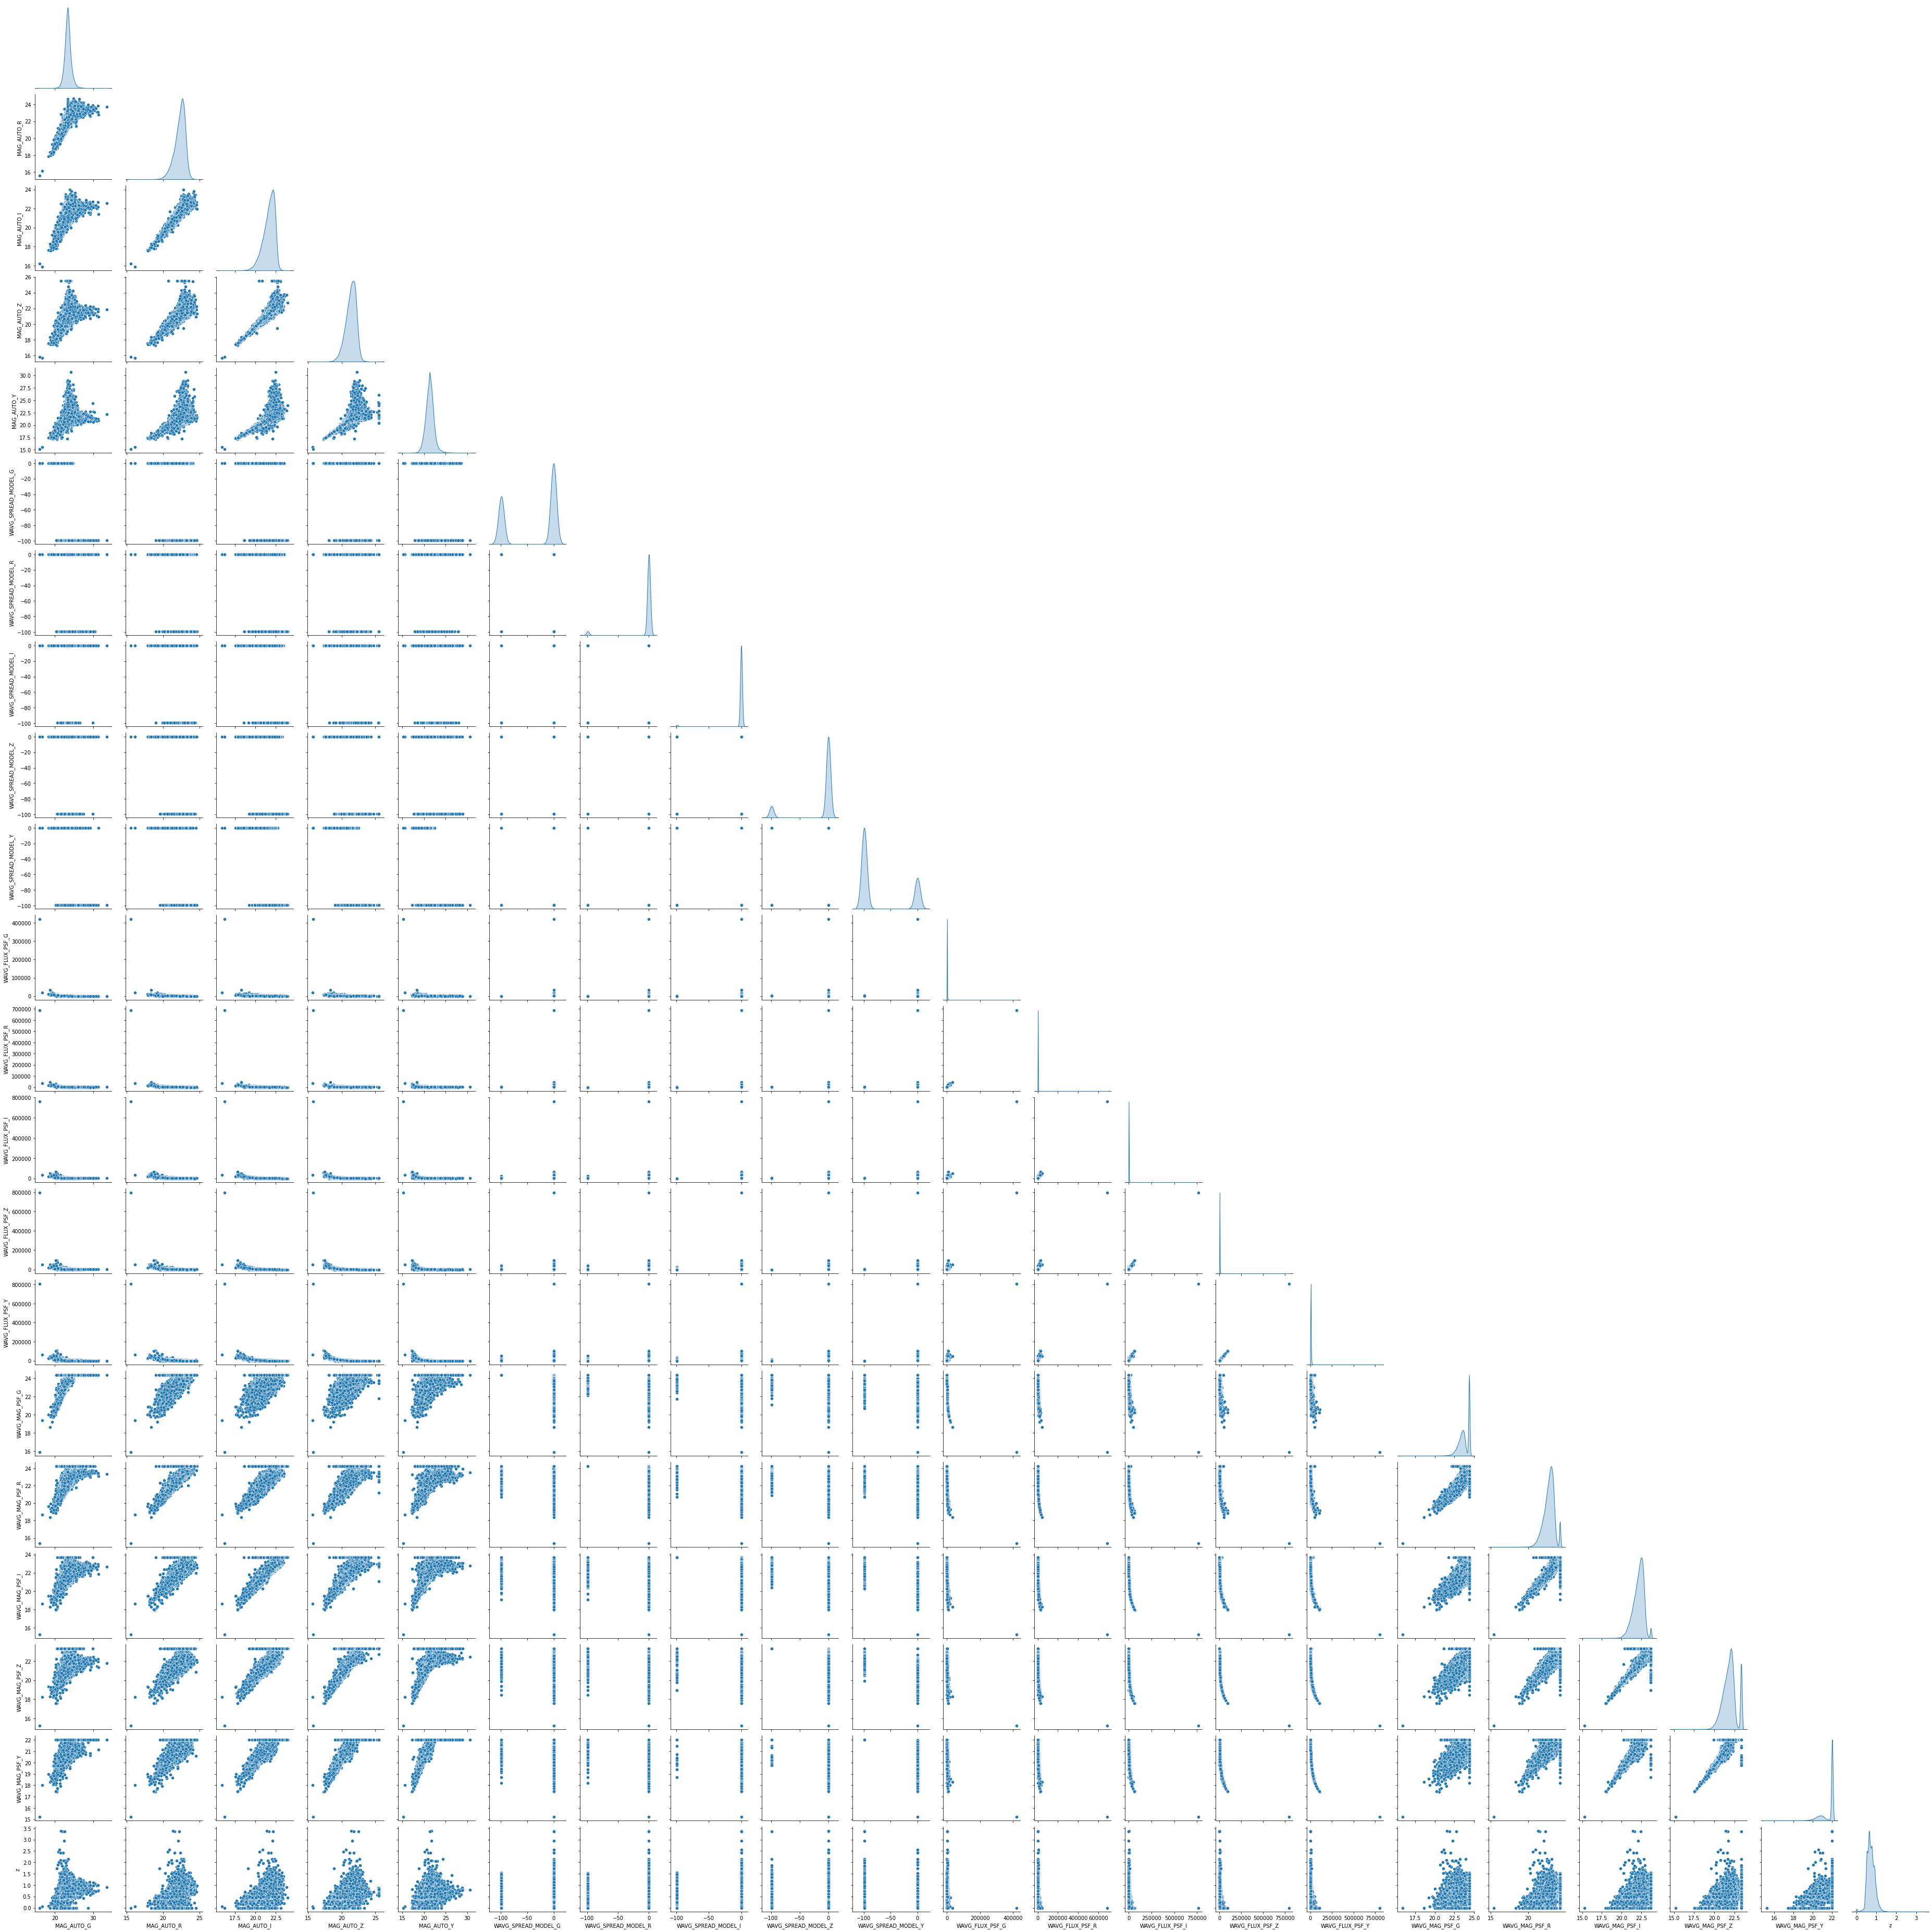

In [52]:
plt.figure(figsize=(16,8))
sns.pairplot(vipers[feat],diag_kind= "kde",corner= True)

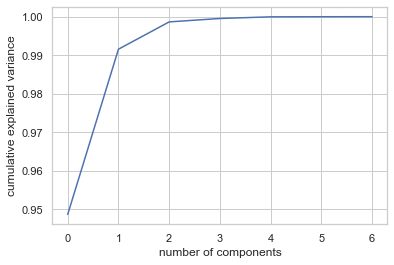

None

Cumulative Variance Ratio  Explained Variance Ratio
0                   0.948636                  0.948636
1                   0.991544                  0.042909
2                   0.998638                  0.007093
3                   0.999526                  0.000888
4                   0.999953                  0.000427
5                   0.999980                  0.000027
6                   0.999990                  0.000010

In [53]:
pca_test = PCA(n_components=7)
pca_test.fit(vipers[feat[0:19]])
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.axvline(linewidth=4, color='r', linestyle = '--', x=2, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [54]:
pca = PCA(n_components=5)

In [55]:
new_feat = pca.fit_transform(vipers[feat[0:19]])


In [56]:
new_components = pd.DataFrame(new_feat,columns=["1 Component","2 Component","3 Component","4 Component","5 Component"])

In [57]:
new_components["z"] = vipers["z"]

In [58]:
new_components.head()

1 Component  2 Component  3 Component  4 Component  5 Component       z
0 -3211.056839   204.146574  -759.527788  -410.282523   330.190782  0.8625
1 -1544.446349  1003.848982   228.984363    75.522863   156.664362  0.8799
2  4799.440207 -2290.465484  -344.400355  -139.443340    79.579192  0.5614
3 -1512.699210   921.509562   399.783417   159.526414   123.747933  0.8175
4 -1710.263431   449.017899   844.138031   106.559898   -56.084477  0.9880

<Figure size 1152x864 with 0 Axes>

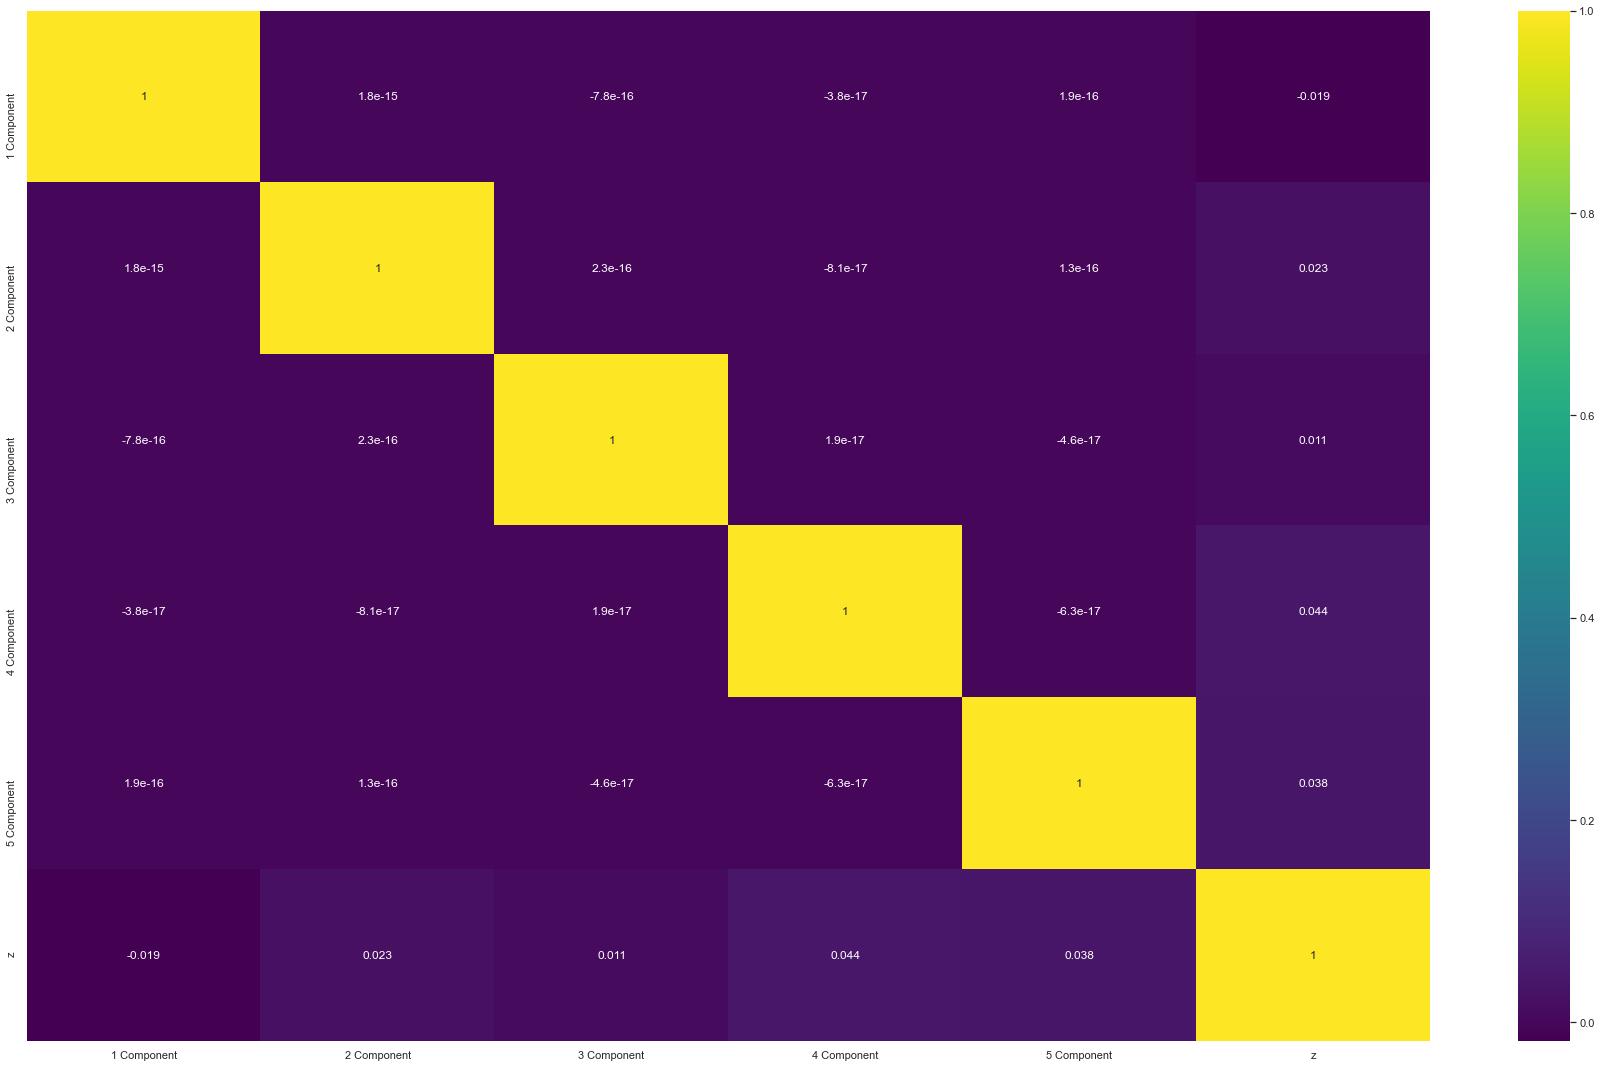

In [59]:
plt.figure(figsize=(16,12))
corrmat1 = new_components.corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat1,annot=True,cmap="viridis")
plt.tight_layout()

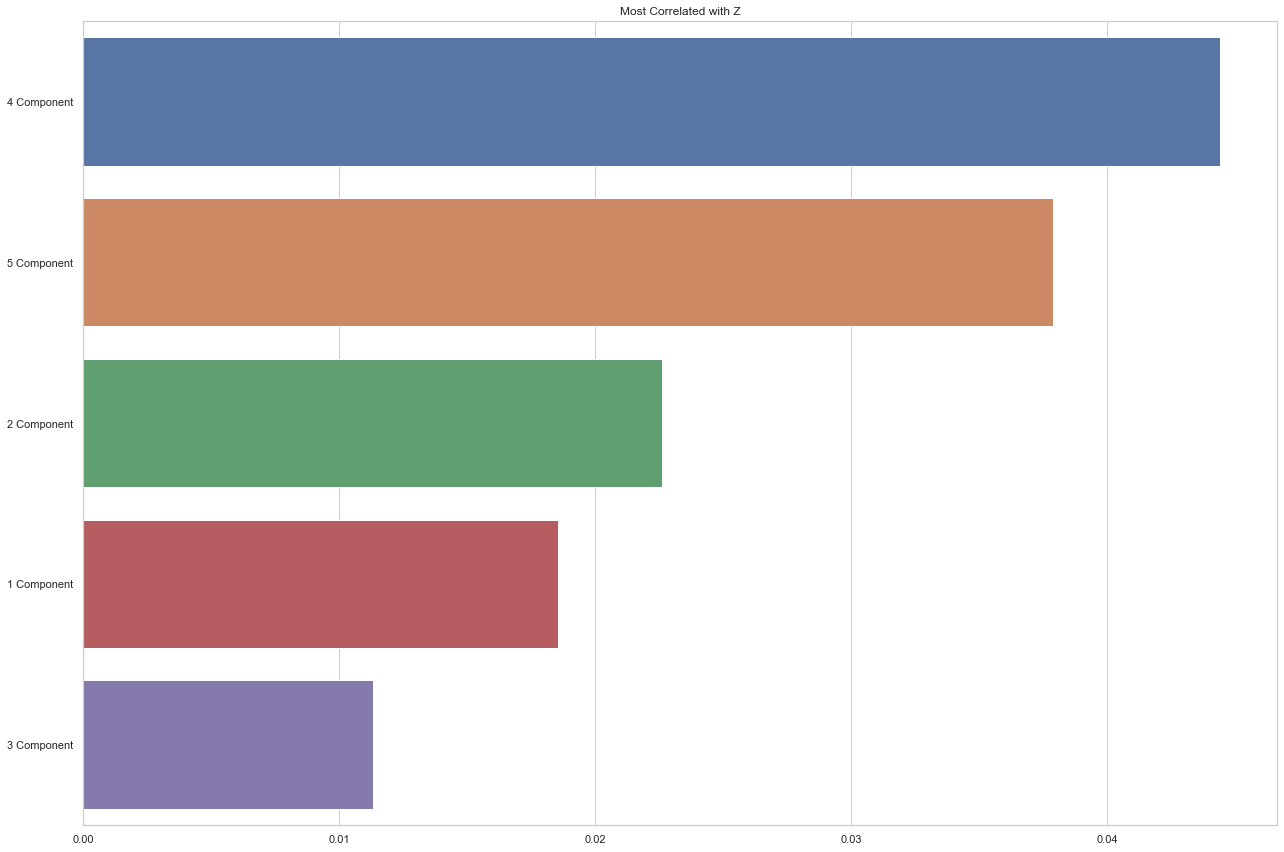

In [60]:
plt.figure(figsize=(18,12))
correlations =corrmat1.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()

<Figure size 1152x576 with 0 Axes>

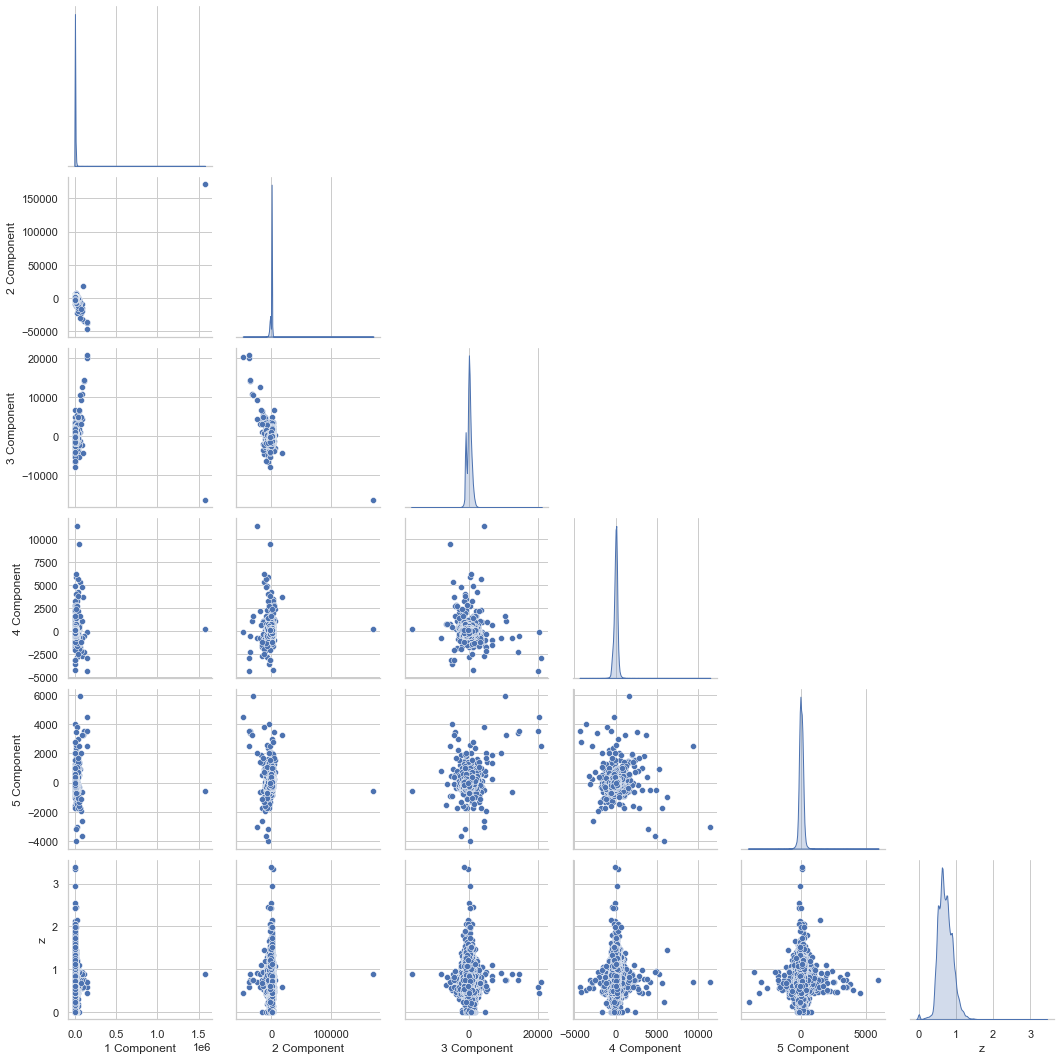

In [61]:
plt.figure(figsize=(16,8))
sns.pairplot(new_components,diag_kind= "kde",corner= True)

## Machine Learning

In [62]:
rob_scaler1 = RobustScaler()
rob_scaler2 = RobustScaler()

In [63]:
features =['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
            "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"]

X = vipers[features].values
y = vipers["z"].values

#X = rob_scaler1.fit_transform(X)
#y = rob_scaler2.fit_transform(y.reshape(-1,1))

In [64]:
X_train, X_test,y_train, y_test = tts_split(X,y,0.3)

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Deep Learning methods

In [66]:
EarlyStop = EarlyStopping(monitor='rmse_ann', mode='min', patience=10)

In [67]:
n_inputs = X_train.shape[1]
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.05),
                       Dense(25, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5),),
                       Dropout(0.45),
                       Dense(25,kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])

In [68]:
cp_path = home+'/PHOTOzxcorr/notebooks/Checkpoint/cp.ckpt'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [69]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
opt = ks.optimizers.Adam(lr=0.001, decay=5e-4)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann, metrics=['mse', 'mae', 'mape',rmse_ann])


In [70]:
history = ann_model.fit(X_train, y_train, epochs=256, validation_data=(X_val,y_val) ,batch_size=32, validation_split=0.1, callbacks=[cp,EarlyStop])


Epoch 1/256
751/751 [==============================] - 2s 2ms/step - loss: 0.1622 - mse: 0.0454 - mae: 0.1609 - mape: 3430492.7500 - rmse_ann: 0.1609 - val_loss: 0.1597 - val_mse: 0.0439 - val_mae: 0.1588 - val_mape: 1607106.3750 - val_rmse_ann: 0.1588
Epoch 2/256
751/751 [==============================] - 1s 2ms/step - loss: 0.1488 - mse: 0.0374 - mae: 0.1480 - mape: 3564239.7500 - rmse_ann: 0.1480 - val_loss: 0.1502 - val_mse: 0.0383 - val_mae: 0.1495 - val_mape: 1697251.2500 - val_rmse_ann: 0.1495
Epoch 3/256
751/751 [==============================] - 1s 2ms/step - loss: 0.1479 - mse: 0.0370 - mae: 0.1472 - mape: 3548268.2500 - rmse_ann: 0.1472 - val_loss: 0.1552 - val_mse: 0.0416 - val_mae: 0.1546 - val_mape: 1636833.5000 - val_rmse_ann: 0.1546
Epoch 4/256
751/751 [==============================] - 1s 1ms/step - loss: 0.1467 - mse: 0.0366 - mae: 0.1460 - mape: 3548332.2500 - rmse_ann: 0.1460 - val_loss: 0.1471 - val_mse: 0.0369 - val_mae: 0.1464 - val_mape: 1705324.2500 - val_rmse_

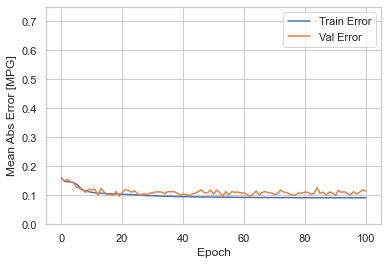

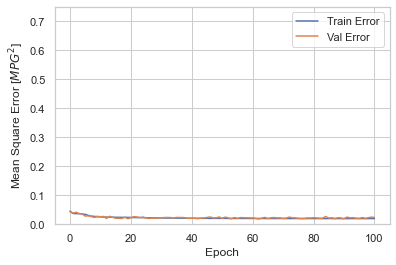

In [71]:
plot_history(history)

In [72]:
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann))

447/447 [==============================] - 0s 1ms/step - loss: 0.1203 - mse: 0.0262 - mae: 0.1187 - mape: 2808550.5000 - rmse_ann: 0.1187
Testing set Mean Abs Error:  0.03 


Testing set Root Mean Abs Error:  0.12 


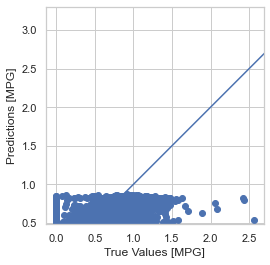

In [73]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


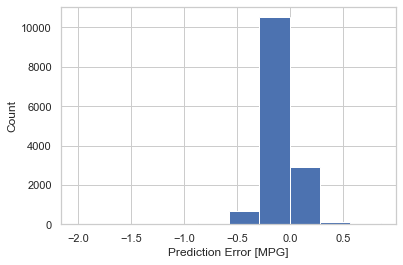

In [74]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we gonna use the this pre-trained model, to try a improvoment

In [75]:
# Loads the weights
ann_model.load_weights(cp_path)

# Re-evaluate the model
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
#print("Restored model, accuracy: {:5.2f}%".format(100 * mae))

447/447 [==============================] - 0s 794us/step - loss: 0.0999 - mse: 0.0208 - mae: 0.0984 - mape: 2962494.0000 - rmse_ann: 0.0984
Testing set Mean Abs Error:  0.02 MPG


In [76]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = home+"/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 16

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
ann_model.save_weights(checkpoint_path.format(epoch=0))
## New optimizer
opt_new = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

ann_model.compile(optimizer=opt_new, loss = "mse", metrics=['mse', 'mae', 'mape'])
# Train the model with the new callback
ann_model.fit(X_train, 
          y_train,
          epochs=256,
          batch_size = 32,
          callbacks=[cp_callback],
          validation_data=(X_val, y_val))

Epoch 1/256
 51/834 [>.............................] - ETA: 0s - loss: 0.0354 - mse: 0.0339 - mae: 0.1357 - mape: 4283695.5000
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001.ckpt
152/834 [====>.........................] - ETA: 0s - loss: 0.0295 - mse: 0.0281 - mae: 0.1201 - mape: 3567722.0000
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001.ckpt
199/834 [======>.......................] - ETA: 0s - loss: 0.0293 - mse: 0.0279 - mae: 0.1202 - mape: 3554248.0000
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001.ckpt
305/834 [=========>....................] - ETA: 0s - loss: 0.0280 - mse: 0.0267 - mae: 0.1174 - mape: 3296005.0000
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001.ckpt
388/834 [============>.................] - ETA: 0s - loss: 0.0272 - mse: 0.0258 - mae: 0.1154 - mape: 3259976.0000
Epoch 00001: saving model

In [77]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0256.ckpt'

In [78]:
# Load the previously saved weights
ann_model.load_weights(latest)

# Re-evaluate the model
loss, mae, mse,mape, = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


447/447 [==============================] - 1s 1ms/step - loss: 0.0589 - mse: 0.0584 - mae: 0.1943 - mape: 2397003.2500
Testing set Mean Abs Error:  0.06 MPG


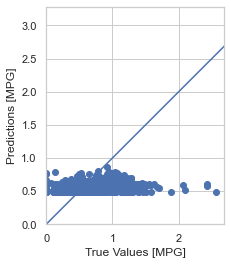

In [79]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [80]:
error = rmsle(y_test,test_predictions)
print("Testing set Mean Abs Error: ",error, " RMSE")

Testing set Mean Abs Error:  0.24161556  RMSE


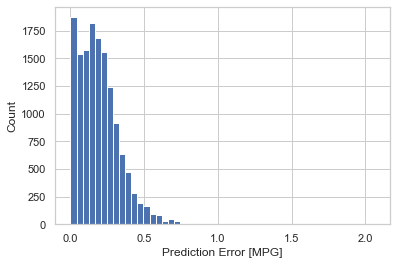

In [81]:
error = np.abs(test_predictions - y_test)
plt.hist(error,bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

(0.0, 100.0)

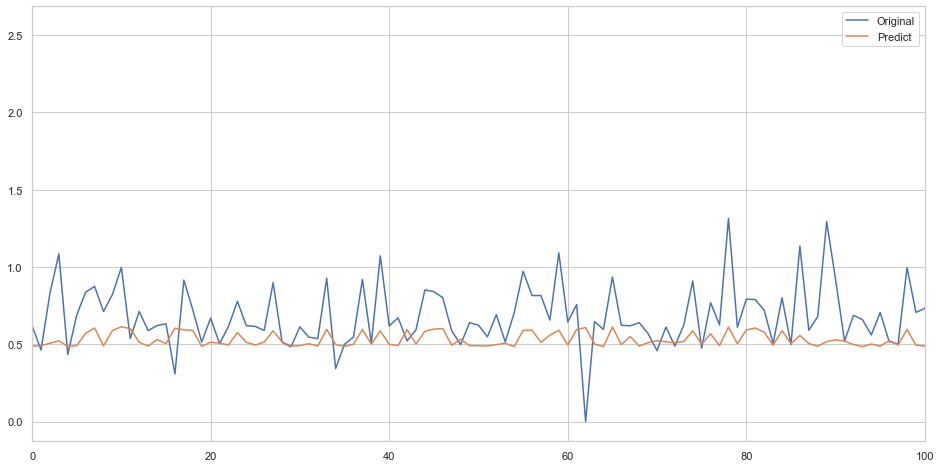

In [82]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label = "Original")
plt.plot(test_predictions,label = "Predict")
plt.legend()
plt.xlim(0,100)

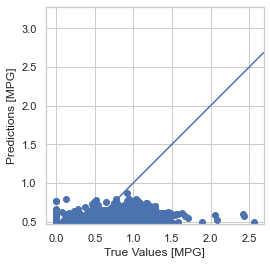

In [83]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


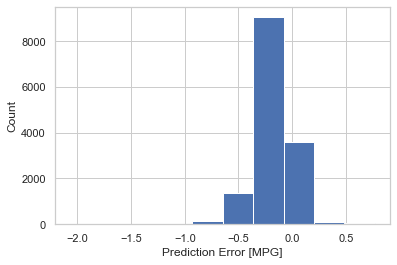

In [84]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## Color space


We now reconstruct the redshift using the colour space

In [85]:
EarlyStop = EarlyStopping(monitor='rmse_ann2', mode='min', patience=10)

In [53]:
def get_features_targets(data):
    features = np.zeros(shape=(len(data), 8))
    
    features[:, 0] = data['MAG_AUTO_G'] - data['MAG_AUTO_R']
    features[:, 1] = data['MAG_AUTO_R'] - data['MAG_AUTO_I']
    features[:, 2] = data['MAG_AUTO_I'] - data['MAG_AUTO_Z']
    features[:, 3] = data['MAG_AUTO_Z'] - data['MAG_AUTO_Y']
    features[:, 4] = data['WAVG_MAG_PSF_G'] - data['WAVG_MAG_PSF_R']
    features[:, 5] = data['WAVG_MAG_PSF_R'] - data['WAVG_MAG_PSF_I']
    features[:, 6] = data['WAVG_MAG_PSF_I'] - data['WAVG_MAG_PSF_Z']
    features[:, 7] = data['WAVG_MAG_PSF_Z'] - data['WAVG_MAG_PSF_Y']

    
    
    targets = data['z']
    return features, targets


In [87]:
X,y = get_features_targets(vipers)


In [88]:
X_train, X_test,y_train, y_test = tts_split(X,y.values,0.3)

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [90]:
n_inputs = X_train.shape[1]
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.05),
                       Dense(25, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.45),
                       Dense(25,kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])

In [91]:
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)                225       
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)                650       
_________________________________________________________________
output (Dense)               (None, 1)                 26        
Total params: 973
Trainable params: 973
Non-trainable params: 0
________________________________________________________

In [92]:
cp_path = home+'/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp_colour.ckpt'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [93]:
opt = ks.optimizers.Adam(lr=0.001, decay=5e-4)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann2, metrics=['mse', 'mae', 'mape',rmse_ann2])

In [94]:
history = ann_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val,y_val) ,batch_size=16, validation_split=0.1, callbacks=[cp,EarlyStop])

Epoch 1/1000
1501/1501 [==============================] - 3s 2ms/step - loss: 0.1181 - mse: 0.0335 - mae: 0.1174 - mape: 3606848.5000 - rmse_ann2: 0.1174 - val_loss: 0.0815 - val_mse: 0.0158 - val_mae: 0.0806 - val_mape: 2845344.0000 - val_rmse_ann2: 0.0806
Epoch 2/1000
1501/1501 [==============================] - 3s 2ms/step - loss: 0.0900 - mse: 0.0199 - mae: 0.0890 - mape: 3582849.2500 - rmse_ann2: 0.0890 - val_loss: 0.0779 - val_mse: 0.0147 - val_mae: 0.0769 - val_mape: 2806463.7500 - val_rmse_ann2: 0.0769
Epoch 3/1000
1501/1501 [==============================] - 3s 2ms/step - loss: 0.0875 - mse: 0.0189 - mae: 0.0864 - mape: 3538671.0000 - rmse_ann2: 0.0864 - val_loss: 0.0751 - val_mse: 0.0140 - val_mae: 0.0739 - val_mape: 2773430.0000 - val_rmse_ann2: 0.0739
Epoch 4/1000
1501/1501 [==============================] - 3s 2ms/step - loss: 0.0864 - mse: 0.0187 - mae: 0.0852 - mape: 3585178.5000 - rmse_ann2: 0.0852 - val_loss: 0.0747 - val_mse: 0.0139 - val_mae: 0.0734 - val_mape: 27287

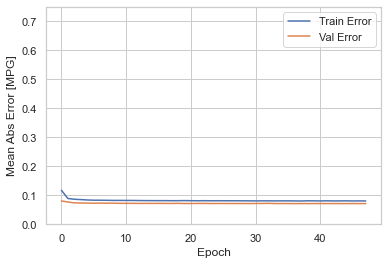

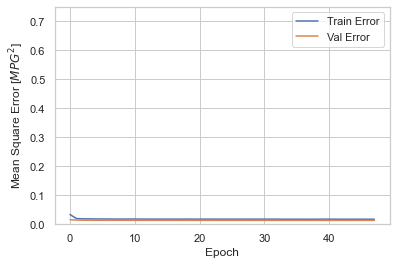

In [95]:
plot_history(history)

In [96]:
loss, mae, mse,mape,rmse_ann2 = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Mean Abs Error: {:5.2f} ".format(rmse_ann2))

447/447 [==============================] - 0s 921us/step - loss: 0.0772 - mse: 0.0153 - mae: 0.0756 - mape: 3244349.5000 - rmse_ann2: 0.0756
Testing set Mean Abs Error:  0.02 


Testing set Mean Abs Error:  0.08 


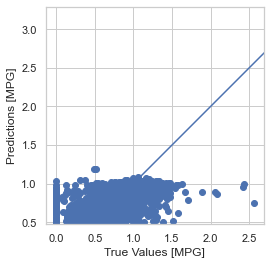

In [97]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


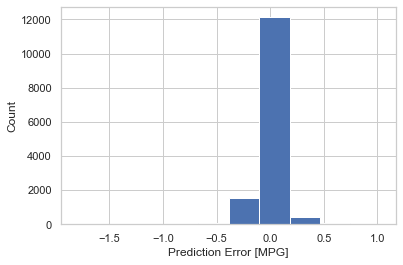

In [98]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we gonna use the this pre-trained model, to try a improvoment

In [99]:
# Loads the weights
ann_model.load_weights(cp_path)

# Re-evaluate the model
loss, mae, mse,mape,rmse_ann2 = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann2))

447/447 [==============================] - 0s 876us/step - loss: 0.0773 - mse: 0.0153 - mae: 0.0757 - mape: 3255611.0000 - rmse_ann2: 0.0757
Testing set Mean Abs Error:  0.02 MPG


Testing set Root Mean Abs Error:  0.08 


In [100]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = home+"/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-{epoch:04d}_colour.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 16

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
ann_model.save_weights(checkpoint_path.format(epoch=0))
## New optimizer
opt_new = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

ann_model.compile(optimizer=opt_new, loss = "mse", metrics=['mse', 'mae', 'mape'])
# Train the model with the new callback
ann_model.fit(X_train, 
          y_train,
          epochs=256,
          batch_size = 32,
          callbacks=[cp_callback],
          validation_data=(X_val, y_val))

Epoch 1/256
 45/834 [>.............................] - ETA: 0s - loss: 0.0179 - mse: 0.0163 - mae: 0.0811 - mape: 3980715.0000
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001_colour.ckpt
131/834 [===>..........................] - ETA: 0s - loss: 0.0162 - mse: 0.0146 - mae: 0.0775 - mape: 2973714.7500
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001_colour.ckpt
212/834 [======>.......................] - ETA: 0s - loss: 0.0173 - mse: 0.0157 - mae: 0.0796 - mape: 3250994.5000
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001_colour.ckpt
298/834 [=========>....................] - ETA: 0s - loss: 0.0189 - mse: 0.0174 - mae: 0.0809 - mape: 3190809.2500
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001_colour.ckpt
391/834 [=============>................] - ETA: 0s - loss: 0.0190 - mse: 0.0175 - mae: 0.0814 - mape: 3398035.00

In [101]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0256_colour.ckpt'

In [102]:
# Load the previously saved weights
ann_model.load_weights(latest)

# Re-evaluate the model
loss, mae, mse,mape = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann2))

447/447 [==============================] - 1s 2ms/step - loss: 0.0157 - mse: 0.0149 - mae: 0.0753 - mape: 3240773.5000
Testing set Mean Abs Error:  0.01 MPG


Testing set Root Mean Abs Error:  0.08 


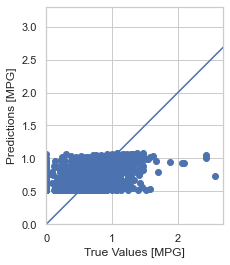

In [103]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [104]:
error = rmsle(y_test,test_predictions)
print("Testing set Mean Abs Error: ",error, " RMSE")

Testing set Mean Abs Error:  0.12210325  RMSE


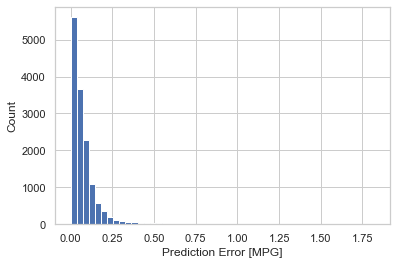

In [105]:
error = np.abs(test_predictions - y_test)
plt.hist(error,bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

(0.0, 50.0)

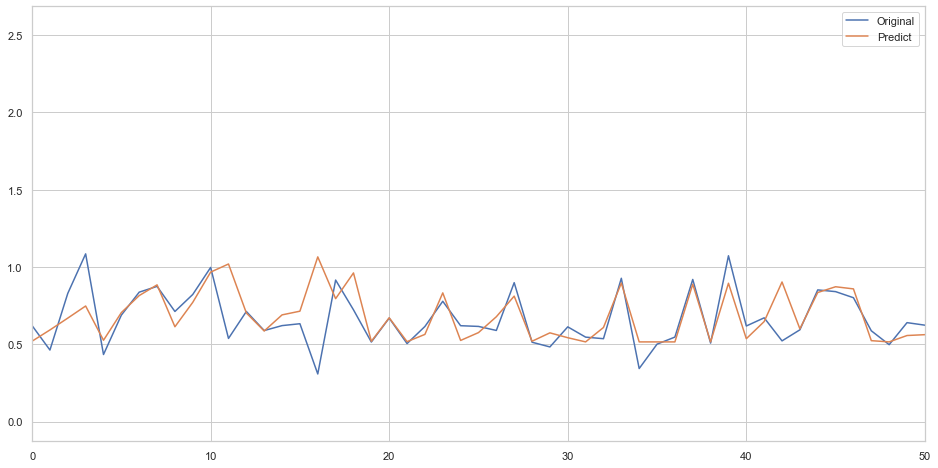

In [106]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label = "Original")
plt.plot(test_predictions,label = "Predict")
plt.legend()
plt.xlim(0,50)

## New method of estimation

Now we will try using the a method of Redshift estimation.
Using the color space plus a two magnitudes 

In [54]:
X,y = get_features_targets(vipers)


In [55]:
EarlyStop = EarlyStopping(monitor='rmse_ann3', mode='min', patience=10)

In [56]:
X = np.concatenate((X,vipers["MAG_AUTO_I"].values.reshape(-1,1)),axis = 1 )
X = np.concatenate((X,vipers["MAG_AUTO_R"].values.reshape(-1,1)),axis = 1 )

In [57]:
X.shape

(47650, 10)

In [58]:
X_train, X_test,y_train, y_test = tts_split(X,y.values,0.3)

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [60]:
n_inputs = X_train.shape[1]
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.05),
                       Dense(25, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.45),
                       Dense(25,kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])

In [61]:
ann_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                275       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
output (Dense)               (None, 1)                 26        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
______________________________________________________

In [62]:
cp_path = home+'/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp_colour.ckpt'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [63]:
opt = ks.optimizers.Adam(lr=0.001, decay=5e-4)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann3, metrics=['mse', 'mae', 'mape',rmse_ann3])

In [64]:
history = ann_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val,y_val) ,batch_size=16, validation_split=0.1, callbacks=[cp,EarlyStop])

Epoch 1/1000
1501/1501 [==============================] - 3s 2ms/step - loss: 0.1278 - mse: 0.0369 - mae: 0.1273 - mape: 3600662.2500 - rmse_ann3: 0.1273 - val_loss: 0.0949 - val_mse: 0.0203 - val_mae: 0.0944 - val_mape: 1451710.2500 - val_rmse_ann3: 0.0944
Epoch 2/1000
1501/1501 [==============================] - 3s 2ms/step - loss: 0.1021 - mse: 0.0241 - mae: 0.1016 - mape: 3723138.2500 - rmse_ann3: 0.1016 - val_loss: 0.0926 - val_mse: 0.0196 - val_mae: 0.0921 - val_mape: 1454226.0000 - val_rmse_ann3: 0.0921
Epoch 3/1000
1501/1501 [==============================] - 2s 2ms/step - loss: 0.1002 - mse: 0.0236 - mae: 0.0997 - mape: 3761078.0000 - rmse_ann3: 0.0997 - val_loss: 0.0913 - val_mse: 0.0191 - val_mae: 0.0907 - val_mape: 1414118.2500 - val_rmse_ann3: 0.0907
Epoch 4/1000
1501/1501 [==============================] - 2s 1ms/step - loss: 0.0960 - mse: 0.0222 - mae: 0.0954 - mape: 3724166.5000 - rmse_ann3: 0.0954 - val_loss: 0.0880 - val_mse: 0.0180 - val_mae: 0.0874 - val_mape: 14231

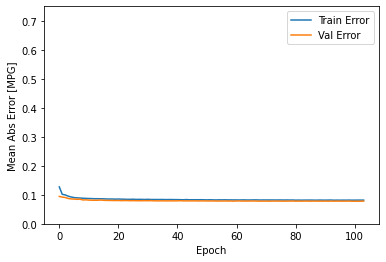

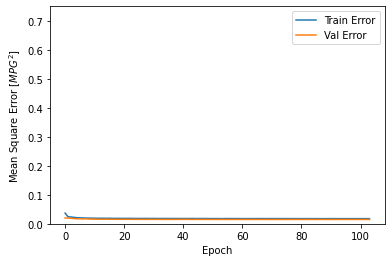

In [65]:
plot_history(history)

In [66]:
loss, mae, mse,mape,rmse_ann2 = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Mean Abs Error: {:5.2f} ".format(rmse_ann2))

447/447 [==============================] - 0s 836us/step - loss: 0.0784 - mse: 0.0156 - mae: 0.0771 - mape: 3234158.0000 - rmse_ann3: 0.0771
Testing set Mean Abs Error:  0.02 


Testing set Mean Abs Error:  0.08 


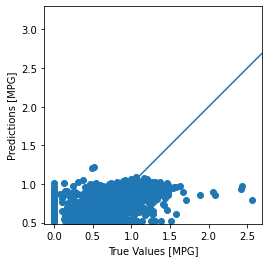

In [67]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


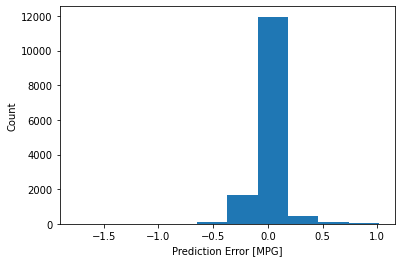

In [68]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we gonna use the this pre-trained model, to try a improvoment

In [69]:
# Loads the weights
ann_model.load_weights(cp_path)

# Re-evaluate the model
loss, mae, mse,mape,rmse_ann2 = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann2))

447/447 [==============================] - 0s 809us/step - loss: 0.0783 - mse: 0.0156 - mae: 0.0771 - mape: 3211386.2500 - rmse_ann3: 0.0771
Testing set Mean Abs Error:  0.02 MPG


Testing set Root Mean Abs Error:  0.08 


In [70]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = home+"/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-{epoch:04d}_colour.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 16

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
ann_model.save_weights(checkpoint_path.format(epoch=0))
## New optimizer
opt_new = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

ann_model.compile(optimizer=opt_new, loss = "mse", metrics=['mse', 'mae', 'mape'])
# Train the model with the new callback
ann_model.fit(X_train, 
          y_train,
          epochs=512,
          batch_size = 32,
          callbacks=[cp_callback],
          validation_data=(X_val, y_val))

Epoch 1/512
 53/834 [>.............................] - ETA: 0s - loss: 0.0172 - mse: 0.0159 - mae: 0.0826 - mape: 2259468.0000
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001_colour.ckpt
145/834 [====>.........................] - ETA: 0s - loss: 0.0169 - mse: 0.0157 - mae: 0.0810 - mape: 3185744.7500
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001_colour.ckpt
236/834 [=======>......................] - ETA: 0s - loss: 0.0179 - mse: 0.0166 - mae: 0.0807 - mape: 2778808.5000
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001_colour.ckpt
276/834 [========>.....................] - ETA: 0s - loss: 0.0180 - mse: 0.0168 - mae: 0.0810 - mape: 3221893.7500
Epoch 00001: saving model to /home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0001_colour.ckpt
374/834 [============>.................] - ETA: 0s - loss: 0.0192 - mse: 0.0180 - mae: 0.0826 - mape: 2934715.25

In [71]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/home/rafael/Projetos/PHOTOzxcorr/notebooks/Checkpoint/cp-0512_colour.ckpt'

In [72]:
# Load the previously saved weights
ann_model.load_weights(latest)

# Re-evaluate the model
loss, mae, mse,mape = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann2))

447/447 [==============================] - 0s 1ms/step - loss: 0.0158 - mse: 0.0151 - mae: 0.0765 - mape: 3183960.0000
Testing set Mean Abs Error:  0.02 MPG


Testing set Root Mean Abs Error:  0.08 


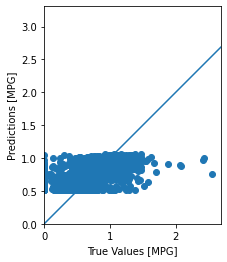

In [73]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [74]:
error = rmsle(y_test,test_predictions)
print("Testing set Mean Abs Error: ",error, " RMSE")

Testing set Mean Abs Error:  0.12283659  RMSE


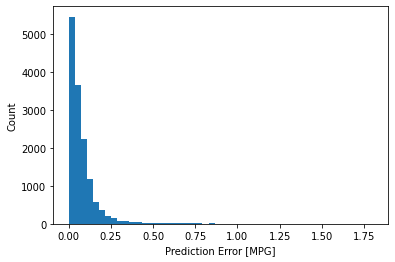

In [75]:
error = np.abs(test_predictions - y_test)
plt.hist(error,bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

(0.0, 50.0)

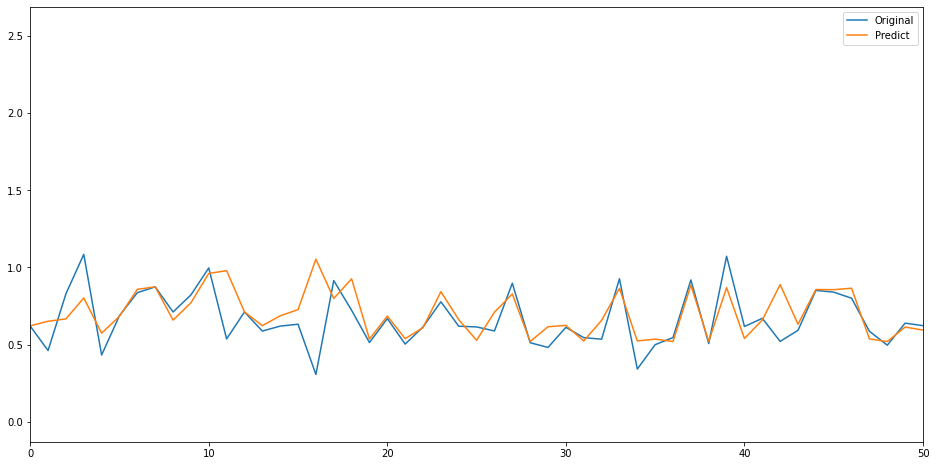

In [76]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label = "Original")
plt.plot(test_predictions,label = "Predict")
plt.legend()
plt.xlim(0,50)